In [ ]:
import pandas as pd
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import xarray as xr
import rioxarray


In [ ]:
STATIONS_FOLDER = "data/ECA_blend_tx/"
TEMPERATURE_FOLDER = "data/ECA_blend_tx/"
NDVI_FOLDER = "data/sentinel2_ndvi/"
GADM_FILE = "data/gadm_410_europe.gpkg"

def dms_to_dd(dms_str):

    dms_str = dms_str.strip()
    parts = dms_str.split(':')
    
    degrees =float(parts[0])
    minutes= float(parts[1])
    seconds =float(parts[2])
    
    if degrees < 0:
        dd=degrees -(minutes/60) - (seconds/3600)
    else:
        dd =degrees + (minutes/60) + (seconds/3600)
        
    return dd


def plot_spatial_overview():

    summer_ndvi_file =os.path.join(NDVI_FOLDER, "ndvi_2020-06-01_2020-09-01.tif")
    print(f"Loading NDVI raster from: {summer_ndvi_file}")
    ndvi_raster = rioxarray.open_rasterio(summer_ndvi_file, masked=True).squeeze()
    print("Downsampling NDVI raster for efficient plotting...")
    downsample_factor = 25
    ndvi_downsampled = ndvi_raster.coarsen(
        x=downsample_factor, y=downsample_factor, boundary="trim"
    ).mean()

    target_crs=ndvi_raster.rio.crs
    print(f"NDVI CRS is: {target_crs}")

    print(f"Loading Europe basemap from: {GADM_FILE}")
    europe_map = gpd.read_file(GADM_FILE)
    europe_map_reprojected = europe_map.to_crs(target_crs)

    stations_file = os.path.join(STATIONS_FOLDER, "stations.txt")
    print(f"Loading station locations from: {stations_file}")
    stations_df = pd.read_csv(stations_file, skiprows=17, header=0, sep=',')
    stations_df.columns = stations_df.columns.str.strip()

    print("Converting station coordinates from DMS to Decimal Degrees...")
    stations_df['LON'] = stations_df['LON'].apply(dms_to_dd)
    stations_df['LAT'] = stations_df['LAT'].apply(dms_to_dd)

    stations_gdf = gpd.GeoDataFrame(
        stations_df, 
        geometry=gpd.points_from_xy(stations_df['LON'], stations_df['LAT']),
        crs="EPSG:4326"
    )
    stations_reprojected= stations_gdf.to_crs(target_crs)

    fig, ax =plt.subplots(1, 1, figsize=(15, 12))
    
    im = ndvi_downsampled.plot(ax=ax, cmap='RdYlGn', add_colorbar=False)
    
    europe_map_reprojected.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)
    stations_reprojected.plot(ax=ax, marker='o', color='blue', markersize=1, alpha=0.6)

    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Normalized Difference Vegetation Index (NDVI)', weight='bold')
    cbar.set_ticks([0, 127, 254])
    cbar.set_ticklabels(['-1.0 (Water/Barren)', '0.0 (No Vegetation)', '1.0 (Dense Vegetation)'])
    ax.set_title('Spatial Data Overview: NDVI and Temperature Stations', fontsize=16, weight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig("plot1_spatial_overview.png", dpi=300)
    print("Plot 1 saved to 'plot1_spatial_overview.png'")
    plt.show()


def plot_temporal_deep_dive():
    STATION_ID_TO_PLOT = 'STAID000020'
    YEAR_TO_PLOT = 2020

    temp_file=os.path.join(TEMPERATURE_FOLDER, f"TX_{STATION_ID_TO_PLOT}.txt")
    print(f"Loading temperature data from: {temp_file}")
    temp_df = pd.read_csv(temp_file, skiprows=19, header=0, sep=',')
    temp_df.columns = temp_df.columns.str.strip()
    temp_df['DATE'] = pd.to_datetime(temp_df['DATE'], format='%Y%m%d')
    temp_df['TX'] /= 10.0
    temp_df_year = temp_df[temp_df['DATE'].dt.year == YEAR_TO_PLOT].copy()
    
    stations_file = os.path.join(STATIONS_FOLDER, "stations.txt")
    stations_df = pd.read_csv(stations_file, skiprows=17, header=0, sep=',')
    stations_df.columns = stations_df.columns.str.strip()
    station_info = stations_df[stations_df['STAID'] == int(STATION_ID_TO_PLOT[5:])].iloc[0]
    
    station_lon =dms_to_dd(station_info['LON'])
    station_lat=dms_to_dd(station_info['LAT'])
    print(f"Found {station_info['STANAME'].strip()} at (Lon: {station_lon:.4f}, Lat: {station_lat:.4f})")
    
    ndvi_files_2020={
        "Q1 (Winter)": "ndvi_2020-01-01_2020-03-01.tif",
        "Q2 (Spring)": "ndvi_2020-03-01_2020-06-01.tif",
        "Q3 (Summer)": "ndvi_2020-06-01_2020-09-01.tif",
        "Q4 (Autumn)": "ndvi_2020-09-01_2020-12-01.tif"
    }
    
    quarterly_ndvi_values = []
    
    def convert_raw_ndvi(raw_val):
        if raw_val ==255: return np.nan
        return (raw_val / 254.0) * 2.0 - 1.0

    print("Sampling quarterly NDVI values at station location...")
    for quarter, filename in ndvi_files_2020.items():
        raster_path = os.path.join(NDVI_FOLDER, filename)
        if not os.path.exists(raster_path):
            print(f"  - WARNING: NDVI file not found: {filename}. Skipping quarter.")
            quarterly_ndvi_values.append(np.nan)
            continue
        with rioxarray.open_rasterio(raster_path) as rds:
            raw_val=rds.sel(x=station_lon, y=station_lat, method="nearest").values[0]
            scaled_val=convert_raw_ndvi(raw_val)
            quarterly_ndvi_values.append(scaled_val)
            print(f"  - {quarter}: {scaled_val:.2f}")

    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax1.plot(temp_df_year['DATE'], temp_df_year['TX'], color='red', label='Daily Max Temperature')
    ax1.set_xlabel('Date', weight='bold')
    ax1.set_ylabel('Temperature (°C)', color='red', weight='bold')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    quarter_dates =[pd.to_datetime(f'{YEAR_TO_PLOT}-02-15'), pd.to_datetime(f'{YEAR_TO_PLOT}-04-15'), pd.to_datetime(f'{YEAR_TO_PLOT}-08-15'), pd.to_datetime(f'{YEAR_TO_PLOT}-10-15')]
    ax2.bar(quarter_dates, quarterly_ndvi_values, width=30, color='green', alpha=0.7, label='Quarterly NDVI')
    ax2.set_ylabel('NDVI', color='green', weight='bold')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(-0.2, 1.0)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.title(f'Temperature and NDVI in {YEAR_TO_PLOT} for Station: {station_info["STANAME"].strip()}', fontsize=16, weight='bold')
    fig.tight_layout()
    plt.savefig("plot2_temporal_deep_dive.png", dpi=300)
    print("Plot 2 saved to 'plot2_temporal_deep_dive.png'")
    plt.show()

--- Generating Plot 1: Spatial Overview Map ---
Loading NDVI raster from: data/sentinel2_ndvi/ndvi_2020-06-01_2020-09-01.tif
Downsampling NDVI raster for efficient plotting...
NDVI CRS is: EPSG:3035
Loading Europe basemap from: data/gadm_410_europe.gpkg
Loading station locations from: data/ECA_blend_tx/stations.txt
Converting station coordinates from DMS to Decimal Degrees...
Plot 1 saved to 'plot1_spatial_overview.png'


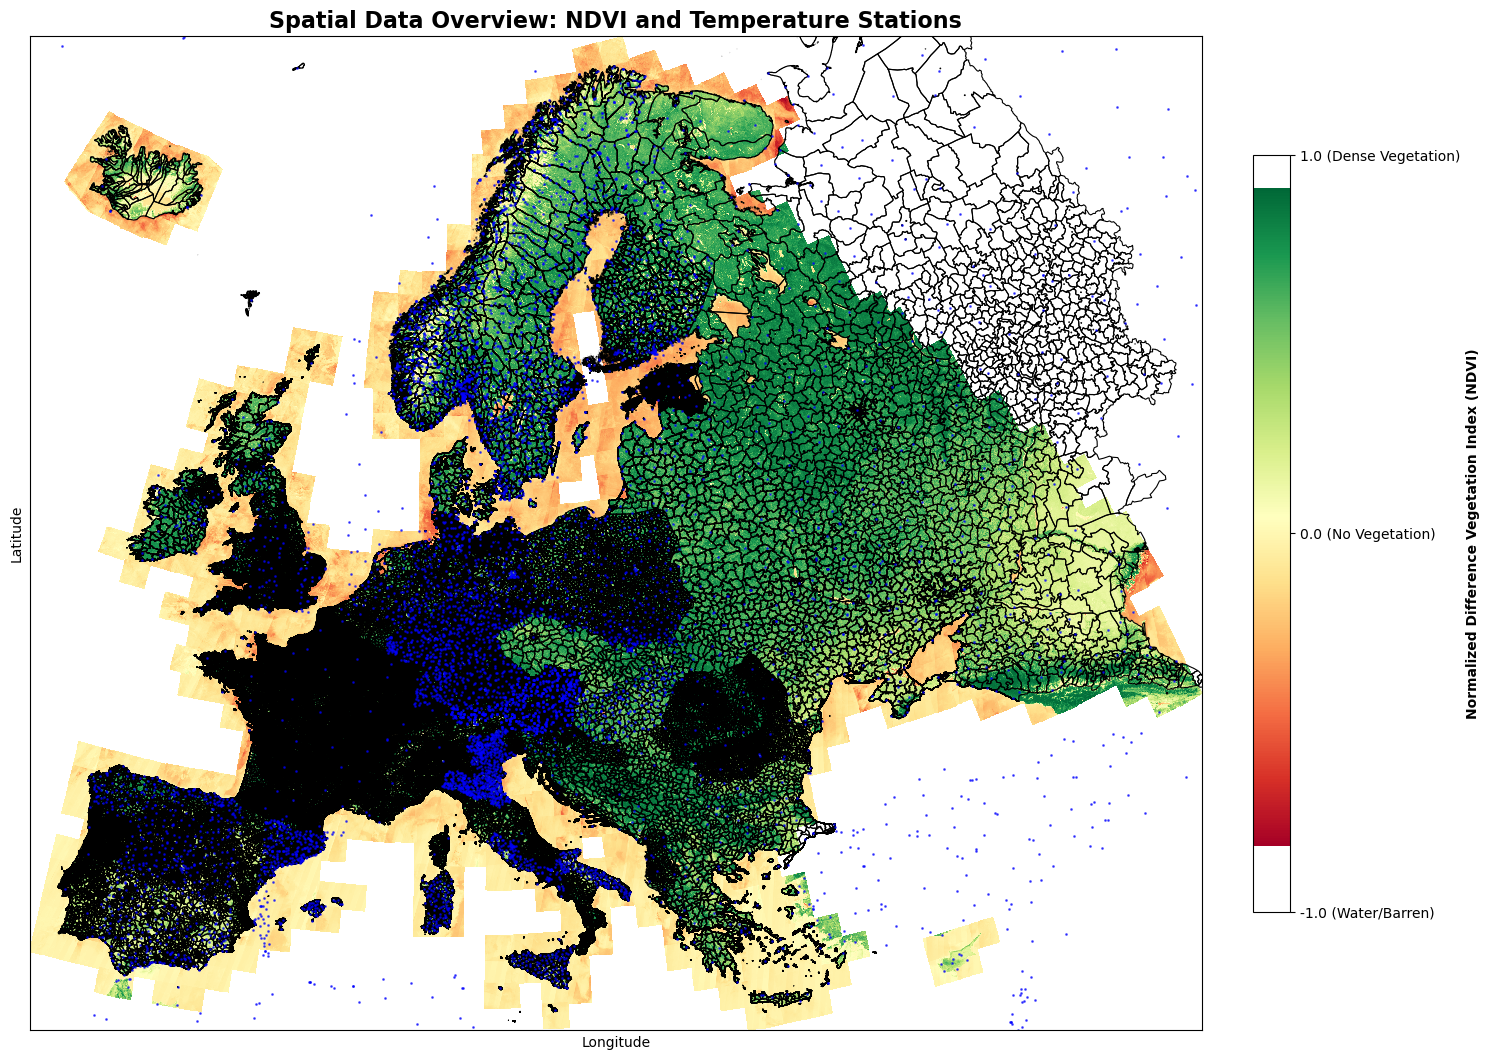


--- Generating Plot 2: Temporal Deep-Dive ---
Loading temperature data from: data/ECA_blend_tx/TX_STAID000020.txt


FileNotFoundError: [Errno 2] No such file or directory: 'data/ECA_blend_tx/TX_STAID000020.txt'

In [ ]:
if not os.path.exists(STATIONS_FOLDER) or not os.path.exists(NDVI_FOLDER):
    print("ERROR: Please update the folder paths in the script's CONFIGURATION section.")
else:
    plot_spatial_overview()
    plot_temporal_deep_dive()

In [ ]:
GADM_FILE_PATH = "data/gadm_410_europe.gpkg"

try:

    gadm_gdf =gpd.read_file(GADM_FILE_PATH)

    level_columns = sorted([col for col in gadm_gdf.columns if col.startswith('NAME_')])

    if not level_columns:
        print("No administrative level columns (e.g., 'NAME_0', 'NAME_1') found.")
    else:
        print("\n--- Count of Empty/Null Entries for Each Administrative Level ---")
        total_rows =len(gadm_gdf)
        print(f"Total rows in the dataset: {total_rows}")

        for level_col in level_columns:
            null_count= gadm_gdf[level_col].isnull().sum()
            level_number =level_col.split('_')[1]
            percentage_empty = (null_count / total_rows) * 100
            print(f"  - Level {level_number} ('{level_col}'): {null_count} empty entries ({percentage_empty:.2f}%)")

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {GADM_FILE_PATH}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading GADM GeoPackage file...
File loaded successfully.

--- Count of Empty/Null Entries for Each Administrative Level ---
Total rows in the dataset: 106252
  - Level 0 ('NAME_0'): 0 empty entries (0.00%)
  - Level 1 ('NAME_1'): 0 empty entries (0.00%)
  - Level 2 ('NAME_2'): 0 empty entries (0.00%)
  - Level 3 ('NAME_3'): 0 empty entries (0.00%)
  - Level 4 ('NAME_4'): 0 empty entries (0.00%)
  - Level 5 ('NAME_5'): 0 empty entries (0.00%)


# Meteolrological data

In [ ]:


NDVI_FOLDER_PATH = "data/sentinel2_ndvi/"
FILE_TO_INSPECT = "ndvi_2020-06-01_2020-09-01.tif"
full_path = os.path.join(NDVI_FOLDER_PATH, FILE_TO_INSPECT)

def convert_ndvi_to_real_scale(ndvi_dataarray):
    if ndvi_dataarray.ndim == 3:
        ndvi_dataarray= ndvi_dataarray.squeeze()
        
    nodata_val= ndvi_dataarray.rio.nodata
    
    values = ndvi_dataarray.values.astype(np.float32)
    
    if nodata_val is not None:
        values[values== nodata_val] = np.nan
    
    scaled_values = (values / 254.0) * 2.0 - 1.0
    
    return xr.DataArray(scaled_values, coords=ndvi_dataarray.coords, dims=ndvi_dataarray.dims)


try:
    rds = rioxarray.open_rasterio(full_path)
    
    ndvi_raw =rds.isel(band=0)

    height, width = ndvi_raw.shape
    crs = ndvi_raw.rio.crs

    ndvi_scaled =convert_ndvi_to_real_scale(ndvi_raw)
    
    min_ndvi =np.nanmin(ndvi_scaled.values)
    
    max_ndvi= np.nanmax(ndvi_scaled.values)

except FileNotFoundError:
    print(f"ERROR: The file could not be found at {full_path}. Please check the path and filename.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Exploring Vegetation Data: ndvi_2020-06-01_2020-09-01.tif ---

--- 1. General File Info ---
Image Dimensions: 61776 pixels wide x 52389 pixels high
Coordinate Reference System (CRS): EPSG:3035
Raw Data Type: uint8
Nodata Value (raw): 255

--- 2. Converting Raw Values to Scientific NDVI Scale ---
Conversion successful.

--- 3. Key Metrics for Your Presentation ---

Fill these into your slide:
  - Each quarterly image is a massive grid of 61776 x 52389 pixels.
  - The data is mapped using the EPSG:3035 projection.
  - In Summer 2020, the highest NDVI value was: 0.99
  - The lowest NDVI value was: -1.00


# ERA-5 LAND

In [ ]:
ERA5_FOLDER_PATH = "data/derived-era5-land-daily-statistics/"
FILE_TO_INSPECT = "2020_2m_temperature_daily_maximum.nc"
full_path = os.path.join(ERA5_FOLDER_PATH, FILE_TO_INSPECT)

try:
    print(f"--- Exploring Meteorological Data: {FILE_TO_INSPECT} ---")
    ds = xr.open_dataset(full_path)

    print("\n--- 1. General Dataset Info ---")
    print(ds)

    print("\n--- 2. Key Data Characteristics ---")
    
    num_time =ds.dims['valid_time']
    num_latitud = ds.dims['latitude']
    num_longitude =ds.dims['longitude']
    
    lat_min, lat_max = ds['latitude'].min().values, ds['latitude'].max().values
    lon_min, lon_max = ds['longitude'].min().values, ds['longitude'].max().values
    time_start, time_end = ds['valid_time'].min().values, ds['valid_time'].max().values
    
    print(f"Temporal Resolution: {num_time} daily entries")
    print(f"Time Range: From {str(time_start)[:10]} to {str(time_end)[:10]}")
    print(f"Spatial Grid: {num_latitude} latitude points x {num_longitude} longitude points")
    print(f"Latitude Range: {lat_min:.2f} to {lat_max:.2f}")
    print(f"Longitude Range: {lon_min:.2f} to {lon_max:.2f}")

    main_variable_name = 't2m'
    if main_variable_name in ds.variables:
        print(f"\n--- 3. Analysis of the '{main_variable_name}' Variable ---")
        variable_info = ds[main_variable_name]
        print(f"  - Long Name: {variable_info.attrs.get('long_name', 'N/A')}")
        print(f"  - Units: {variable_info.attrs.get('units', 'N/A')}")
        max_temp_k = variable_info.max().item()
        min_temp_k = variable_info.min().item()
        
        max_temp_c = max_temp_k - 273.15
        min_temp_c = min_temp_k - 273.15
        
        print("\n--- 4. Key Metrics for Your Presentation ---")
        print(f"Fill these into your slide:")
        print(f"  - The dataset covers {num_latitude} latitude points and {num_longitude} longitude points.")
        print(f"  - In 2020, the highest temperature recorded was: {max_temp_c:.2f} °C")
        print(f"  - The lowest maximum daily temperature was: {min_temp_c:.2f} °C")

    else:
        print(f"Could not find the expected variable '{main_variable_name}' in the file.")

except FileNotFoundError:
    print(f"ERROR: The file could not be found at {full_path}. Please check the path and filename.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Exploring Meteorological Data: 2020_2m_temperature_daily_maximum.nc ---

--- 1. General Dataset Info ---
<xarray.Dataset> Size: 338MB
Dimensions:     (valid_time: 366, latitude: 350, longitude: 660)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
Data variables:
    t2m         (valid_time, latitude, longitude) float32 338MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

--- 2. Key Data Characteristics ---
Temporal Resolution: 366 daily entries
Time Range: 

C:\Users\drugm\AppData\Local\Temp\ipykernel_19676\1567076607.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_time = ds.dims['valid_time']
C:\Users\drugm\AppData\Local\Temp\ipykernel_19676\1567076607.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_latitude = ds.dims['latitude']
C:\Users\drugm\AppData\Local\Temp\ipykernel_19676\1567076607.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Da


--- 4. Key Metrics for Your Presentation ---
Fill these into your slide:
  - The dataset covers 350 latitude points and 660 longitude points.
  - In 2020, the highest temperature recorded was: 48.15 °C
  - The lowest maximum daily temperature was: -30.67 °C


# NDVI

In [ ]:

NDVI_FOLDER_PATH = "data/sentinel2_ndvi/"
FILE_TO_INSPECT= "ndvi_2020-06-01_2020-09-01.tif"
full_path = os.path.join(NDVI_FOLDER_PATH, FILE_TO_INSPECT)

def convert_ndvi_to_real_scale(ndvi_dataarray):

    if ndvi_dataarray.ndim == 3:
        ndvi_dataarray = ndvi_dataarray.squeeze()
        
    nodata_val = ndvi_dataarray.rio.nodata
    values = ndvi_dataarray.values.astype(float)
    
    if nodata_val is not None:
        values[values == nodata_val] = np.nan

    scaled_values= (values / 254.0) * 2.0 - 1.0
    
    return xr.DataArray(scaled_values, coords=ndvi_dataarray.coords, dims=ndvi_dataarray.dims)


try:
    print(f"--- Exploring Vegetation Data: {FILE_TO_INSPECT} ---")
    rds= rioxarray.open_rasterio(full_path)
    
    ndvi_raw = rds.isel(band=0)

    print("\n--- 1. General File Info ---")
    height, width = ndvi_raw.shape
    crs = ndvi_raw.rio.crs
    
    print(f"Image Dimensions: {width} pixels wide x {height} pixels high")
    print(f"Coordinate Reference System (CRS): {crs}")
    print(f"Raw Data Type: {ndvi_raw.dtype}")
    print(f"Nodata Value (raw): {ndvi_raw.rio.nodata}")

    ndvi_scaled = convert_ndvi_to_real_scale(ndvi_raw)

    min_ndvi =np.nanmin(ndvi_scaled.values)
    max_ndvi= np.nanmax(ndvi_scaled.values)
    
    print("\n--- 3. Key Metrics for Your Presentation ---")
    print(f"Fill these into your slide:")
    print(f"  - Each quarterly image is a massive grid of {width} x {height} pixels.")
    print(f"  - The data is mapped using the {crs} projection.")
    print(f"  - In Summer 2020, the highest NDVI value was: {max_ndvi:.2f}")
    print(f"  - The lowest NDVI value was: {min_ndvi:.2f}")

except FileNotFoundError:
    print(f"ERROR: The file could not be found at {full_path}. Please check the path and filename.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Exploring Vegetation Data: ndvi_2020-06-01_2020-09-01.tif ---

--- 1. General File Info ---
Image Dimensions: 61776 pixels wide x 52389 pixels high
Coordinate Reference System (CRS): EPSG:3035
Raw Data Type: uint8
Nodata Value (raw): 255

--- 2. Converting Raw Values to Scientific NDVI Scale ---
Conversion successful.

--- 3. Key Metrics for Your Presentation ---
Fill these into your slide:
  - Each quarterly image is a massive grid of 61776 x 52389 pixels.
  - The data is mapped using the EPSG:3035 projection.
  - In Summer 2020, the highest NDVI value was: 0.99
  - The lowest NDVI value was: -1.00
